In [1]:
import keras.callbacks
import tensorflow as tf
from keras.layers import Dense, Input, Dropout, MaxPooling1D, Conv1D, GlobalMaxPool1D
from keras.layers import LSTM, Lambda, concatenate, TimeDistributed, Bidirectional

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, Embedding, Activation, Flatten, Dense
from keras.layers import Conv1D, MaxPooling1D, Dropout
from keras.models import Model
from keras.layers import LeakyReLU

In [0]:
import re
with open('/content/drive/My Drive/Colab Notebooks/nlp assignment 3/train.txt') as fp:
	lineList = fp.readlines()

tempTrainData = []
tempList = []
for item in lineList:
	item = re.sub(r'\t',' ',item)
	item = re.sub(r'\n','',item)
	temp = item.split(' ')
	if len(temp)==3:
		tempTrainData.append(tempList)
		tempTrainData.append([temp[2]])
		tempList = [' ']
	else:
		tempList.append(temp[0])

trainData = np.array(tempTrainData)

dataList = []
sentiList = []

for i in range(len(trainData)):
	s = ''
	for item in trainData[i]:
		s = s+' '+item
	
	if s == '' or s == ' ':
		pass
	elif s == ' positive' or s== ' negative' or s==' neutral':
		s = re.sub(r'','',s)
		sentiList.append(s)
	else:
		dataList.append(s)

del sentiList[len(sentiList)-1]


In [0]:
with open('/content/drive/My Drive/Colab Notebooks/nlp assignment 3/test.txt') as fp:
	lineList = fp.readlines()

tempTestData = []
tempTestList = []
for item in lineList:
	item = re.sub(r'\t',' ',item)
	item = re.sub(r'\n','',item)
	temp = item.split(' ')
	if len(temp)==3:
		tempTestData.append(tempTestList)
		tempTestData.append([temp[2]])
		tempTestList = [' ']
	else:
		tempTestList.append(temp[0])

testData = np.array(tempTestData)

dataTestList = []
sentiTestList = []

for i in range(len(testData)):
	s = ''
	for item in testData[i]:
		s = s+' '+item
	
	if s == '' or s == ' ':
		pass
	elif s == ' positive' or s== ' negative' or s==' neutral':
		s = re.sub(r'','',s)
		sentiTestList.append(s)
	else:
		dataTestList.append(s)

del sentiTestList[len(sentiTestList)-1]

train_arr=dataList
test_arr=dataTestList
train_arr_senti=sentiList
test_arr_senti=sentiTestList


In [0]:

train_texts = train_arr[:]
train_texts = [s.lower() for s in train_texts]

test_texts = test_arr[:]
test_texts = [s.lower() for s in test_texts]

tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(train_texts)

train_sequences = tk.texts_to_sequences(train_texts)
test_texts = tk.texts_to_sequences(test_texts)
train_data = pad_sequences(train_sequences, maxlen=170, padding='post')
test_data = pad_sequences(test_texts, maxlen=170, padding='post')
train_data = np.array(train_data)
test_data = np.array(test_data)
train_classes_1 = train_arr_senti[:]
train_class_list = []

for i in train_classes_1:
  if(i == ' positive'):
    train_class_list.append(0)
  elif(i == ' negative'):
    train_class_list.append(1)
  else:
    train_class_list.append(2)

train_class_list = np.array(train_class_list)

test_classes_1 = test_arr_senti[:]
test_class_list = []

for i in test_classes_1:
  if(i == ' positive'):
    test_class_list.append(0)
  elif(i == ' negative'):
    test_class_list.append(1)
  else:
    test_class_list.append(2)

test_class_list = np.array(test_class_list)

from keras.utils import to_categorical

train_classes = to_categorical(train_class_list)
test_classes = to_categorical(test_class_list)

In [9]:

input_size = 170
vocab_size = len(tk.word_index)
print(tk.word_index)
embedding_size = 899
conv_layers = [[256, 2, 4],
               [256, 2, 4],
               [256, 2, -1],
               [256, 2, -1],
               [256, 2, -1],
               [256, 2, 4]]

fully_connected_layers = [1024, 1024]
num_of_classes = 3
dropout_p = 0.5
optimizer = 'Adamax'
loss = 'categorical_crossentropy'


embedding_weights = [] 
embedding_weights.append(np.zeros(vocab_size))  

for char, i in tk.word_index.items():
    onehot = np.zeros(vocab_size)
    onehot[i - 1] = 1
    embedding_weights.append(onehot)

embedding_weights = np.array(embedding_weights)
embedding_layer = Embedding(vocab_size+1,embedding_size, weights=[embedding_weights])
inputs = Input(shape=(input_size,), name='input', dtype='int64') 
x = embedding_layer(inputs)
for filter_num, filter_size, pooling_size in conv_layers:
    x = Conv1D(filter_num, filter_size)(x)
    x = LeakyReLU(alpha=0.05)(x)
    if pooling_size != -1:
        x = MaxPooling1D(pool_size=pooling_size)(x)  

x = Flatten()(x)

for dense_size in fully_connected_layers:
    x = Dense(dense_size, activation='linear')(x)
    x = LeakyReLU(alpha=0.05)(x)
    x = Dropout(dropout_p)(x)

predictions = Dense(num_of_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy']) 
model.summary()

indices = np.arange(train_data.shape[0])
np.random.shuffle(indices)
x_train = train_data[indices]
y_train = train_classes[indices]

x_test = test_data
y_test = test_classes


{'UNK': 1, ' ': 2, 'a': 3, 'i': 4, 'e': 5, 'h': 6, 't': 7, 'o': 8, 'r': 9, 's': 10, 'n': 11, 'k': 12, 'm': 13, 'l': 14, 'd': 15, 'u': 16, 'p': 17, 'b': 18, 'y': 19, 'c': 20, 'g': 21, '/': 22, '@': 23, '.': 24, 'j': 25, 'w': 26, 'f': 27, 'v': 28, '…': 29, 'z': 30, '_': 31, '1': 32, '0': 33, 'q': 34, '2': 35, 'x': 36, '3': 37, '9': 38, '5': 39, '4': 40, '7': 41, '8': 42, '6': 43, '#': 44, '!': 45, '😂': 46, '?': 47, "'": 48, '-': 49, '’': 50, '️': 51, '🙏': 52, '❤': 53, '🤣': 54, '😍': 55, '&': 56, ')': 57, '(': 58, '😭': 59, '*': 60, '😘': 61, '🇮': 62, '🇳': 63, '😊': 64, '🌹': 65, '💜': 66, '🎂': 67, '“': 68, '💕': 69, 'ा': 70, '😁': 71, '👏': 72, '🎉': 73, '💖': 74, '👍': 75, '|': 76, '👌': 77, '”': 78, '✌': 79, '😜': 80, '%': 81, 'र': 82, '😆': 83, '💐': 84, '🏻': 85, '+': 86, '♥': 87, '🤗': 88, '्': 89, '😎': 90, '😡': 91, '🙄': 92, '🔥': 93, '~': 94, '🤔': 95, '\u200d': 96, '😉': 97, '💙': 98, '😠': 99, '😅': 100, '🙌': 101, '\U0001f92a': 102, '😀': 103, 'न': 104, 'क': 105, 'म': 106, ';': 107, '🌸': 108, '💓': 109, '

In [0]:
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class Metrics(Callback):
  def __init__(self, logs={}):
    self.val_f1s = []
    self.val_recalls = []
    self.val_precisions = []
 
  def on_epoch_end(self, epoch, logs={}):
    val_predict = (np.asarray(self.model.predict(x_test))).round()
    val_targ = y_test
    _val_f1 = f1_score(val_targ, val_predict,average=None)
    _val_recall = recall_score(val_targ, val_predict,average=None)
    _val_precision = precision_score(val_targ, val_predict,average=None)
    self.val_f1s.append(_val_f1)
    self.val_recalls.append(_val_recall)
    self.val_precisions.append(_val_precision)
    print(" f1_score_Class1: %f \t f1_score_Class2: %f \t f1_score_Class3: %f \n precision_Class1: %f \t precision_Class2: %f \t precision_Class3: %f \n recall_Class1 %f \t recall_Class2 %f \t recall_Class3 %f" %(_val_f1[0], _val_f1[1], _val_f1[2], _val_precision[0], _val_precision[1], _val_precision[2], _val_recall[0], _val_recall[1], _val_recall[2]))
    return
 
metrics = Metrics()

In [11]:
hist = model.fit(x_train, y_train,validation_data=(x_test, y_test),batch_size=64,epochs=30,verbose=1,callbacks=[metrics])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15130 samples, validate on 1868 samples
Epoch 1/30
15130/15130 [==============================] - 197s 13ms/step - loss: 1.0656 - acc: 0.4052 - val_loss: 1.0429 - val_acc: 0.4481


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 f1_score_Class1: 0.237017 	 f1_score_Class2: 0.000000 	 f1_score_Class3: 0.194503 
 precision_Class1: 0.526627 	 precision_Class2: 0.000000 	 precision_Class3: 0.479167 
 recall_Class1 0.152921 	 recall_Class2 0.000000 	 recall_Class3 0.122016
Epoch 2/30
15130/15130 [==============================] - 198s 13ms/step - loss: 0.9752 - acc: 0.4995 - val_loss: 1.0195 - val_acc: 0.4781
 f1_score_Class1: 0.555095 	 f1_score_Class2: 0.345361 	 f1_score_Class3: 0.005291 
 precision_Class1: 0.536000 	 precision_Class2: 0.549180 	 precision_Class3: 1.000000 
 recall_Class1 0.575601 	 recall_Class2 0.251880 	 recall_Class3 0.002653
Epoch 3/30
15130/15130 [==============================] - 196s 13ms/step - loss: 0.9207 - acc: 0.5409 - val_loss: 0.9916 - val_acc: 0.5128
 f1_score_Class1: 0.537342 	 f1_score_Class2: 0.529884 	 f1_score_Class3: 0.063131 
 precision_Class1: 0.616927 	 precision_Class2: 0.504244 	 precision_Class3: 0.657895 
 recall_Class1 0.475945 	 recall_Class2 0.558271 	 recall_Cla

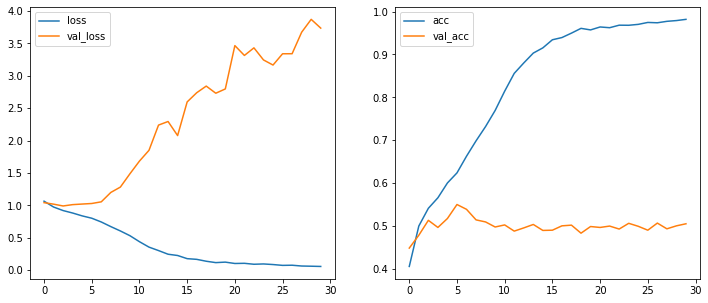

In [12]:
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.figure(figsize=(12,5)) 
plt.subplot(121) 
plt.plot(hist.history['loss'], label='loss') 
plt.plot(hist.history['val_loss'], label='val_loss') 
plt.legend() 
plt.subplot(122) 
plt.plot(hist.history['acc'], label='acc') 
plt.plot(hist.history['val_acc'], label='val_acc') 
plt.legend() 